In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import xml.etree.ElementTree as ET
from glob import glob 
from collections import Counter
from tqdm import tqdm

In [31]:
class_names = ['0','1','2','3','4','5','6','7','8','9','0','.']
map_classes = dict(zip(class_names, range(len(class_names))))

In [4]:
## voc to dataset

In [6]:
paths = glob('dataset/digital_digit/annotations/*.xml')

In [7]:
anno_path = 'dataset/digital_digit/anno_digit.txt'

## voc -> anntations format

In [42]:
with open(anno_path, 'w') as f:
    for path in paths:
        root = ET.parse(path).getroot()
        filename = root.find('filename').text
        
        root = ET.parse(path).getroot()
        filename = root.find('filename').text
        save_path = os.path.join('images', filename)

        objects = []
        for o in root.findall('object'):
            class_name = o.find('name').text
            idx = map_classes[class_name]

            box = o.find('bndbox')
            x1 = box.find('xmin').text
            y1 = box.find('ymin').text
            x2 = box.find('xmax').text
            y2 = box.find('ymax').text

            objects.append('{},{},{},{},{}'.format(x1, y1, x2, y2, idx))
            
        row = save_path + ' ' + ' '.join(objects)
        f.write('{}\n'.format(row))

# 학습데이터 확인

In [44]:
with open(anno_path) as f:
    print('학습 데이터 개수', len(f.readlines()))

학습 데이터 개수 100


### Annotation 포맷 확인
- [filepath] [x1,y1,x2,y2,class_index] [x1,y1,x2,y2,class_index] [x1,y1,x2,y2,class_index]

In [45]:
with open(anno_path) as f:
    preview = 0
    for row in f.readlines():
        print(row)
        if preview < 5:
            preview += 1
        else:
            break

images/clock38.jpg 1020,455,1063,516,10 1249,459,1290,514,10 1385,459,1430,517,10 1527,464,1566,516,10 1405,757,1443,813,10 645,473,655,510,1 1223,458,1247,510,1 1107,564,1150,678,1 1377,758,1400,807,1 610,334,648,397,2 590,403,630,467,2 599,471,628,511,2 973,458,1015,514,2 1067,457,1107,513,2 1109,455,1154,514,2 663,472,691,510,2 691,472,720,510,2 1289,563,1373,685,2 1340,458,1381,515,3 1487,461,1520,518,3 1162,562,1241,683,5 1524,758,1566,814,6 655,334,686,395,7 1408,565,1473,681,7 632,404,670,466,9 697,342,727,396,9 680,385,692,399,11 1248,581,1285,622,11 1250,629,1285,669,11 958,768,1000,806,11

images/clock10.jpg 690,473,719,511,10 1020,455,1063,516,10 1249,459,1290,514,10 1385,459,1430,517,10 1527,464,1566,516,10 1405,757,1443,813,10 644,473,655,510,1 1223,458,1247,510,1 1107,564,1150,678,1 1377,758,1400,807,1 610,334,648,397,2 590,403,630,467,2 599,471,628,511,2 973,458,1015,514,2 1067,457,1107,513,2 1109,455,1154,514,2 1340,458,1381,515,3 1487,461,1520,518,3 661,472,691,512,4 1

In [49]:
data_info = []
with open(anno_path) as f:
    preview = 0
    for row in f.readlines():
        if preview < 5:
            preview += 1

        cols = row.split()
        for idx, value in enumerate(cols):
            if idx == 0:
                filepath = value
            else:
                x,y,w,h,label = value.split(',')
                data_info.append([filepath, x,y,w,h, label])

pd_dataset = pd.DataFrame(data_info, columns=['filepath', 'x1', 'y1','x2', 'y2', 'label'])
pd_dataset.head()

,filepath,x1,y1,x2,y2,label
0,images/clock38.jpg,1020,455,1063,516,10
1,images/clock38.jpg,1249,459,1290,514,10
2,images/clock38.jpg,1385,459,1430,517,10
3,images/clock38.jpg,1527,464,1566,516,10
4,images/clock38.jpg,1405,757,1443,813,10


### 이미지 샘플

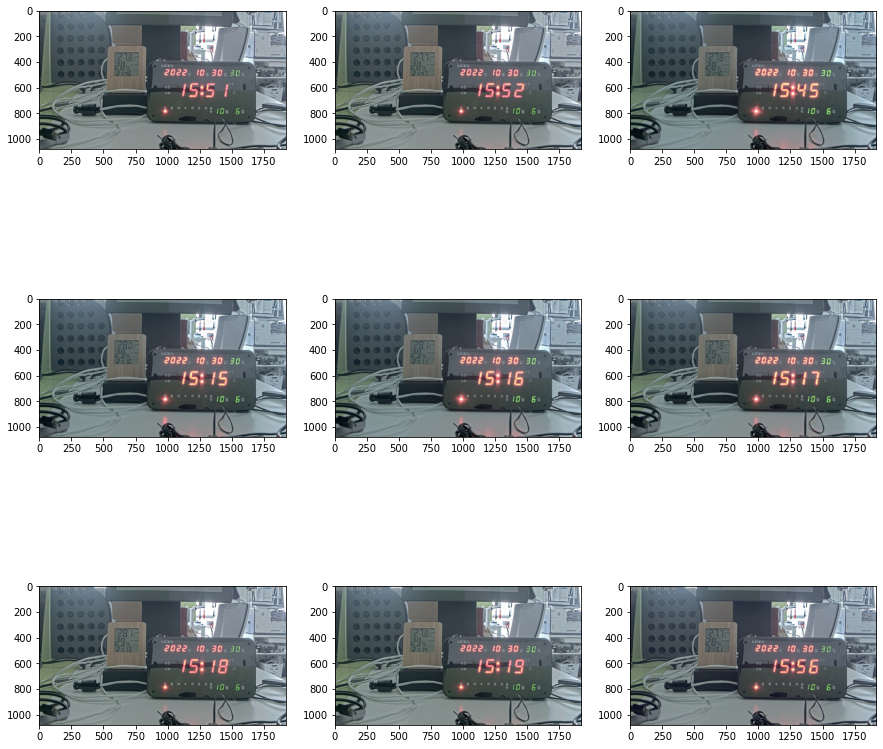

In [50]:
fig = plt.figure(figsize=(15, 15))
rows = 3
cols = 3

groups = pd_dataset.groupby('filepath').size()
files = groups.keys()
for idx in range(0, rows*cols):
    filepath = os.path.join(os.path.dirname(anno_path), files[idx])
    img = cv2.imread(filepath)
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

### 오브젝트의 클래스 개수 확인

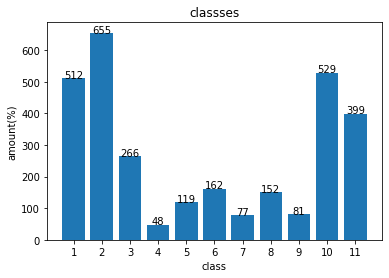

In [52]:
classes_info = pd_dataset.label.value_counts().sort_index(key=lambda x: x.astype(int))
plt.bar(classes_info.index.values, classes_info.values)

total_count = sum(classes_info.values)

for idx, value in enumerate(classes_info.index.values):
    plt.text(idx, classes_info.values[idx], classes_info.values[idx], horizontalalignment="center")

plt.title('classses')
plt.xlabel('class')
plt.ylabel('amount(%)')
plt.show()

In [53]:
image_shapes= []
for path in tqdm(pd_dataset.filepath):
    filepath = os.path.join(os.path.dirname(anno_path), path)
    img_h, img_w, _ = cv2.imread(filepath).shape
    image_shapes.append([img_w, img_h])

100%|██████████| 3000/3000 [01:07<00:00, 44.43it/s]


In [54]:
image_info = []

for idx, (img_w, img_h) in tqdm(enumerate(image_shapes)):
    object_w = int(pd_dataset.iloc[idx]['x2']) - int(pd_dataset.iloc[idx]['x1'])
    object_h = int(pd_dataset.iloc[idx]['y2']) - int(pd_dataset.iloc[idx]['y1'])
    
    image_info.append([img_w, img_h, object_w, object_h, object_w/img_w, object_h/img_h])

image_info = np.array(image_info)

3000it [00:00, 3479.15it/s]


### 이미지 크기 확인

In [55]:
image_info.mean(axis=0)[:2]

array([1920., 1080.])

In [56]:
obj_cnt = pd_dataset.groupby('filepath').size()
num_obj_imgs = Counter(obj_cnt.tolist())
max_cnt = obj_cnt.max()

x = np.arange(1, max_cnt+1)
y = [ num_obj_imgs[idx] if idx in num_obj_imgs else 0  for idx in x ]

# 이미지 당 오브젝트 개수 확인

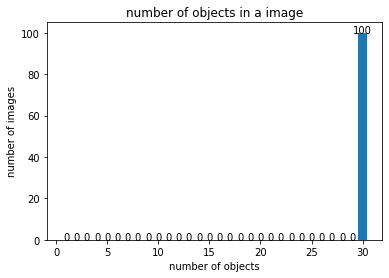

In [57]:
length = len(x)

plt.bar(x, y)

for idx in range(length):
    plt.text(x[idx], y[idx], int(y[idx]), ha='center')

plt.title('number of objects in a image')
plt.xlabel('number of objects')
plt.ylabel('number of images')
plt.show()

### 오브젝트의 크기 분포

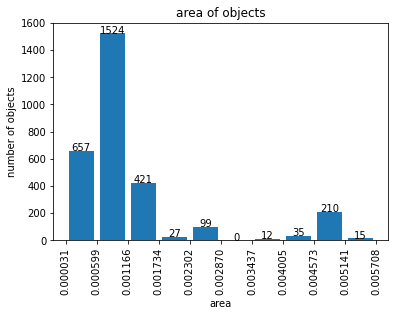

In [58]:
bins = 10
areas = image_info[:,4] * image_info[:,5]
ys, xs, patches = plt.hist(areas, bins=bins, rwidth=0.8)

xs_t = [(xs[i] + xs[i+1])/2 for i in range(0, len(xs)-1)]

for idx in range(bins):
    plt.text(xs_t[idx], ys[idx], int(ys[idx]), ha='center')

plt.xticks(xs, rotation=90)
plt.title('area of objects')
plt.xlabel('area')
plt.ylabel('number of objects')
plt.show()

In [59]:
print('오브젝트 평균 크기(w, h, w(%), h(%))', image_info.mean(axis=0)[2:])
print('최대크기', image_info.max(axis=0)[2:])
print('최소크기', image_info.min(axis=0)[2:])

오브젝트 평균 크기(w, h, w(%), h(%)) [3.83216667e+01 5.95523333e+01 1.99592014e-02 5.51410494e-02]
최대크기 [9.10000000e+01 1.35000000e+02 4.73958333e-02 1.25000000e-01]
최소크기 [7.00000000e+00 8.00000000e+00 3.64583333e-03 7.40740741e-03]


512it [00:12, 42.57it/s]
529it [00:12, 42.72it/s]
399it [00:09, 42.48it/s]
655it [00:15, 42.38it/s]
266it [00:06, 42.58it/s]
48it [00:01, 42.69it/s]
119it [00:02, 43.17it/s]
162it [00:03, 43.25it/s]
77it [00:01, 42.08it/s]
152it [00:03, 43.38it/s]
81it [00:01, 42.97it/s]


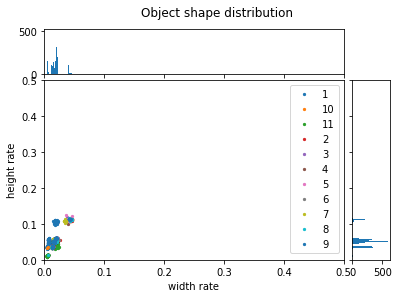

In [60]:
groups = pd_dataset.groupby('label')

fig = plt.figure()

gs = fig.add_gridspec(2, 2,  
                      width_ratios=(8, 1), height_ratios=(2, 8),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
plt.subplots
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[1, 1])

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

binwidth = 50
ax_histx.hist(image_info[:,4], bins=binwidth)
ax_histy.hist(image_info[:,5], bins=binwidth, orientation='horizontal')

ax_histx.set_xlim((0,0.5))
ax_histy.set_ylim((0,0.5))

for name, group in groups:
    info = []
    for idx, path in tqdm(enumerate(group.filepath)):
        filepath = os.path.join(os.path.dirname(anno_path), path)
        img_h, img_w, _ = cv2.imread(filepath).shape
        object_w = int(group.iloc[idx]['x2']) - int(group.iloc[idx]['x1'])
        object_h = int(group.iloc[idx]['y2']) - int(group.iloc[idx]['y1'])

        info.append([object_w/img_w, object_h/img_h])

    info = np.array(info)
    ax.scatter(info[:,0], info[:,1], s=5, label=name)

ax.legend()
ax.set_xlim((0,0.5))
ax.set_ylim((0,0.5))

fig.suptitle('Object shape distribution')
ax.set_xlabel('width rate')
ax.set_ylabel('height rate')
plt.show()

100%|██████████| 3000/3000 [00:03<00:00, 781.89it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


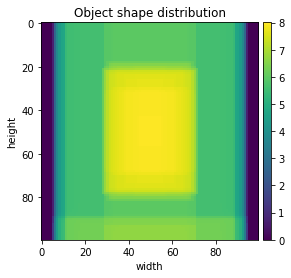

In [63]:
MAT_SIZE = 100
CENTER = int(MAT_SIZE/2)
mat = np.zeros([MAT_SIZE, MAT_SIZE]) # center 49
for image in tqdm(image_info):
    w, h = image[2], image[3]
    half_w = int(w / 2)
    half_h = int(h / 2)
    
    for i in range( CENTER - half_h, min(CENTER + half_h, MAT_SIZE)):
        for j in range( CENTER - half_w, min(CENTER + half_w, MAT_SIZE)):
            mat[i][j] += 1

mat = np.nan_to_num(np.log(mat), neginf=0)

fig = plt.figure()
ax = plt.axes()
im = ax.matshow(mat)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
ax.set_title('Object shape distribution')
ax.set_xlabel('width')
ax.set_ylabel('height')
ax.xaxis.tick_bottom()

plt.show()

### 오브젝트의 위치 분포

3000it [00:00, 3405.17it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


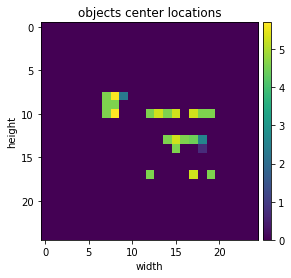

In [64]:
MAT_SIZE = 25
mat = np.zeros([MAT_SIZE,MAT_SIZE]) # center 49

for idx, (img_w, img_h) in tqdm(enumerate(image_shapes)):
    x = (int(pd_dataset.iloc[idx]['x2']) + int(pd_dataset.iloc[idx]['x1'])) /2 
    y = (int(pd_dataset.iloc[idx]['y2']) + int(pd_dataset.iloc[idx]['y1'])) /2
    idx_x = int(min(x / img_w * (MAT_SIZE-1), MAT_SIZE-1))
    idx_y = int(min(y / img_h * (MAT_SIZE-1), MAT_SIZE-1))
    mat[idx_y][idx_x] += 1    


mat = np.nan_to_num(np.log(mat), neginf=0)

fig = plt.figure()
ax = plt.axes()
im = ax.matshow(mat)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
ax.set_title('objects center locations')
ax.set_xlabel('width')
ax.set_ylabel('height')
ax.xaxis.tick_bottom()


plt.show()

# 모델 학습
* --anno-path 학습데이터셋의 Annotation 파일 위치 지정
* --num-epochs 학습 횟수
* --batch-size 배치 사이즈
* --initial-lr 시작 런닝레이트 지정
* --checkpoints-dir 모델 저장 위치
    * 10 epoch 단위로 ssd_epoch_{EPOCH_INDEX}.h5 파일로 저장
    * 마지막 학습 결과는 ssd_epoch_latest.h5 라는 이름으로 저장됨

In [65]:
!python3 model/tensorflow/yolo/train.py \
--anno-path 'dataset/digital_digit/anno_digit.txt' \
--checkpoint-dir /check_points/ssd-clock  --batch-size 64 --initial-lr 0.001 --num-epochs 2 

2022-11-04 11:55:22.519462: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 11:55:22.979645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5
2022-11-04 11:55:23.887711: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8500
loaded weight check_points/ssd/ssd_epoch_latest.h5
0it [00:00, ?it/s]2022-11-04 11:55:24.851166: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
tf.Tensor(
[11 11 11 11 11  2  2  2  2  2  3  3  3  3  

# 모델 예측
* --anno-path 테스트 데이터셋의 위치 지정
* --model-path 로드할 모델의 위치

In [168]:
!python3 model/tensorflow/ssd/inference.py \
--anno-path 'dataset/server_room/test_digit.txt' \
--model-path check_points/ssd/ssd_epoch_100.h5

2022-10-31 05:10:19,722 - Namespace(anno_path='dataset/server_room/test_digit.txt', arch='ssd300', display=False, gpu_id='0', model_path='check_points/ssd/ssd_epoch_100.h5', num_examples=-1, pretrained_type='specified', save=False)
2022-10-31 05:10:19,722 - model loading.. check_points/ssd/ssd_epoch_100.h5
2022-10-31 05:10:19.767598: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 05:10:20.265024: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5
2022-10-31 05:10:21.277107: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369

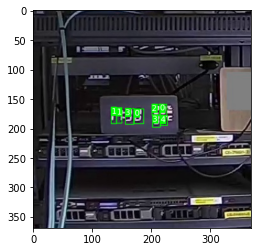

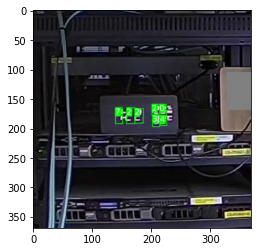

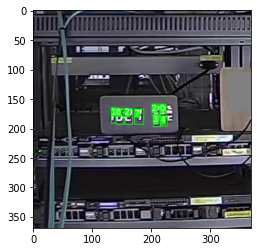

In [174]:
plt.imshow(cv2.imread('check_points/ssd/outputs/images/0.png'))
plt.show()
plt.imshow(cv2.imread('check_points/ssd/outputs/images/1.png'))
plt.show()
plt.imshow(cv2.imread('check_points/ssd/outputs/images/2.png'))
plt.show()